# If you like it, Do Upvote :)

In [1]:
import sys
sys.path.append('../input/iterative-stratification/iterative-stratification-master')
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [2]:
!pip install git+https://github.com/titu1994/tf-TabNet.git
!pip install tabnet[gpu]

  Cloning https://github.com/titu1994/tf-TabNet.git to /tmp/pip-req-build-2obmkq3f
  Created wheel for tabnet: filename=tabnet-0.1.6-py2.py3-none-any.whl size=16193 sha256=206a78556b91d0770e39b40708a1ffbb64ce85f7aee41f2d4f45b5d6ff88b9ad
  Stored in directory: /tmp/pip-ephem-wheel-cache-1y7tkzi9/wheels/ed/f4/a5/1e028b195ef60cabf0c8324b664297f1c901990c310b54d2ed
Successfully built tabnet
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
     |████████████████████████████████| 320.4 MB 22 kB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
#from tabnet.tabnet import TabNet
#from tabnet.tabnet import TabNetClassifier 
#from tabnet import StackedTabNet


In [4]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import os
import copy
import seaborn as sns

from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FactorAnalysis, FastICA, TruncatedSVD

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential,load_model,Model
from tensorflow.keras.layers import Dense, Dropout, Input,LeakyReLU,BatchNormalization,MaxPool2D,Concatenate,Conv2D,Reshape
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.3.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [5]:
os.listdir('../input/lish-moa')

['sample_submission.csv',
 'train_drug.csv',
 'train_targets_scored.csv',
 'train_targets_nonscored.csv',
 'train_features.csv',
 'test_features.csv']

In [6]:
train_features = pd.read_csv('../input/lish-moa/train_features.csv')
train_targets_scored = pd.read_csv('../input/lish-moa/train_targets_scored.csv')
train_targets_nonscored = pd.read_csv('../input/lish-moa/train_targets_nonscored.csv')

test_features = pd.read_csv('../input/lish-moa/test_features.csv')
sample_submission = pd.read_csv('../input/lish-moa/sample_submission.csv')

In [7]:
GENES = [col for col in train_features.columns if col.startswith('g-')]
CELLS = [col for col in train_features.columns if col.startswith('c-')]
Others = [col for col in train_features.columns if (col not in GENES) and (col not in CELLS)]

In [8]:
from sklearn.preprocessing import QuantileTransformer
for col in (GENES + CELLS):

    transformer = QuantileTransformer(n_quantiles=100,random_state=0, output_distribution="normal")
    vec_len = len(train_features[col].values)
    vec_len_test = len(test_features[col].values)
    raw_vec = train_features[col].values.reshape(vec_len, 1)
    transformer.fit(raw_vec)

    train_features[col] = transformer.transform(raw_vec).reshape(1, vec_len)[0]
    test_features[col] = transformer.transform(test_features[col].values.reshape(vec_len_test, 1)).reshape(1, vec_len_test)[0]

In [9]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
seed_everything(seed=42)

In [10]:
train_targets_scored.sum()[1:].sort_values()

atp-sensitive_potassium_channel_antagonist      1
erbb2_inhibitor                                 1
diuretic                                        6
autotaxin_inhibitor                             6
protein_phosphatase_inhibitor                   6
                                             ... 
serotonin_receptor_antagonist                 404
dopamine_receptor_antagonist                  424
cyclooxygenase_inhibitor                      435
proteasome_inhibitor                          726
nfkb_inhibitor                                832
Length: 206, dtype: object

In [11]:
train_features['cp_type'].unique()

array(['trt_cp', 'ctl_vehicle'], dtype=object)

# PCA features + Existing features

In [12]:
# GENES
n_comp = 600  #<--Update

data = pd.concat([pd.DataFrame(train_features[GENES]), pd.DataFrame(test_features[GENES])])
data2 = (TruncatedSVD(n_components=n_comp, n_iter=7, random_state=42).fit_transform(data[GENES]))
train2 = data2[:train_features.shape[0]]; test2 = data2[-test_features.shape[0]:]

train2 = pd.DataFrame(train2, columns=[f'pca_G-{i}' for i in range(n_comp)])
test2 = pd.DataFrame(test2, columns=[f'pca_G-{i}' for i in range(n_comp)])

# drop_cols = [f'c-{i}' for i in range(n_comp,len(GENES))]
train_features = pd.concat((train_features, train2), axis=1)
test_features = pd.concat((test_features, test2), axis=1)

#data2 = (TruncatedSVD(n_components=n_comp, n_iter=7, random_state=42).fit_transform(data[GENES]))
#train2 = data2[:train_features.shape[0]]; test2 = data2[-test_features.shape[0]:]

#train2 = pd.DataFrame(train2, columns=[f'svd_G-{i}' for i in range(n_comp)])
#test2 = pd.DataFrame(test2, columns=[f'svd_G-{i}' for i in range(n_comp)])

# drop_cols = [f'c-{i}' for i in range(n_comp,len(GENES))]
#train_features = pd.concat((train_features, train2), axis=1)
#test_features = pd.concat((test_features, test2), axis=1)

In [13]:
#CELLS
n_comp = 50  #<--Update

data = pd.concat([pd.DataFrame(train_features[CELLS]), pd.DataFrame(test_features[CELLS])])
data2 = (TruncatedSVD(n_components=n_comp, n_iter=7, random_state=42).fit_transform(data[CELLS]))
train2 = data2[:train_features.shape[0]]; test2 = data2[-test_features.shape[0]:]

train2 = pd.DataFrame(train2, columns=[f'pca_C-{i}' for i in range(n_comp)])
test2 = pd.DataFrame(test2, columns=[f'pca_C-{i}' for i in range(n_comp)])

# drop_cols = [f'c-{i}' for i in range(n_comp,len(CELLS))]
train_features = pd.concat((train_features, train2), axis=1)
test_features = pd.concat((test_features, test2), axis=1)

#data2 = (TruncatedSVD(n_components=n_comp, n_iter=7, random_state=42).fit_transform(data[CELLS]))
#train2 = data2[:train_features.shape[0]]; test2 = data2[-test_features.shape[0]:]

#train2 = pd.DataFrame(train2, columns=[f'fa_C-{i}' for i in range(n_comp)])
#test2 = pd.DataFrame(test2, columns=[f'fa_C-{i}' for i in range(n_comp)])

#train_features = pd.concat((train_features, train2), axis=1)
#test_features = pd.concat((test_features, test2), axis=1)

In [14]:
train_features.shape

(23814, 1526)

# feature Selection using Variance Encoding

In [15]:
from sklearn.feature_selection import VarianceThreshold


var_thresh = VarianceThreshold(0.8)  #<-- Update
data = train_features.append(test_features)
data_transformed = var_thresh.fit_transform(data.iloc[:, 4:])

train_features_transformed = data_transformed[ : train_features.shape[0]]
test_features_transformed = data_transformed[-test_features.shape[0] : ]


train_features = pd.DataFrame(train_features[['sig_id','cp_type','cp_time','cp_dose']].values.reshape(-1, 4),\
                              columns=['sig_id','cp_type','cp_time','cp_dose'])

train_features = pd.concat([train_features, pd.DataFrame(train_features_transformed)], axis=1)


test_features = pd.DataFrame(test_features[['sig_id','cp_type','cp_time','cp_dose']].values.reshape(-1, 4),\
                             columns=['sig_id','cp_type','cp_time','cp_dose'])

test_features = pd.concat([test_features, pd.DataFrame(test_features_transformed)], axis=1)

train_features.shape

(23814, 1040)

In [16]:
from sklearn.cluster import KMeans
def fe_cluster(train, test, n_clusters_g = 35, n_clusters_c = 5, SEED = 123):
    
    features_g = list(train.columns[4:776])
    features_c = list(train.columns[776:876])
    
    def create_cluster(train, test, features, kind = 'g', n_clusters = n_clusters_g):
        train_ = train[features].copy()
        test_ = test[features].copy()
        data = pd.concat([train_, test_], axis = 0)
        kmeans = KMeans(n_clusters = n_clusters, random_state = SEED).fit(data)
        train[f'clusters_{kind}'] = kmeans.labels_[:train.shape[0]]
        test[f'clusters_{kind}'] = kmeans.labels_[train.shape[0]:]
        train = pd.get_dummies(train, columns = [f'clusters_{kind}'])
        test = pd.get_dummies(test, columns = [f'clusters_{kind}'])
        return train, test
    
    train, test = create_cluster(train, test, features_g, kind = 'g', n_clusters = n_clusters_g)
    train, test = create_cluster(train, test, features_c, kind = 'c', n_clusters = n_clusters_c)
    return train, test

train_features_ ,test_features_ =fe_cluster(train_features,test_features)
#train_features = pd.concat((train_features, train_features_), axis=1)
#test_features = pd.concat((test_features, test_features_), axis=1)

In [17]:
def fe_stats(train, test):
    
    features_g = list(train.columns[4:776])
    features_c = list(train.columns[776:876])
    
    for df in train, test:
        df['g_sum'] = df[features_g].sum(axis = 1)
        df['g_mean'] = df[features_g].mean(axis = 1)
        df['g_std'] = df[features_g].std(axis = 1)
        df['g_kurt'] = df[features_g].kurtosis(axis = 1)
        df['g_skew'] = df[features_g].skew(axis = 1)
        df['c_sum'] = df[features_c].sum(axis = 1)
        df['c_mean'] = df[features_c].mean(axis = 1)
        df['c_std'] = df[features_c].std(axis = 1)
        df['c_kurt'] = df[features_c].kurtosis(axis = 1)
        df['c_skew'] = df[features_c].skew(axis = 1)
        df['gc_sum'] = df[features_g + features_c].sum(axis = 1)
        df['gc_mean'] = df[features_g + features_c].mean(axis = 1)
        df['gc_std'] = df[features_g + features_c].std(axis = 1)
        df['gc_kurt'] = df[features_g + features_c].kurtosis(axis = 1)
        df['gc_skew'] = df[features_g + features_c].skew(axis = 1)
        
    return train, test

train_features,test_features=fe_stats(train_features,test_features)

In [18]:
train = train_features.merge(train_targets_scored, on='sig_id')
train = train[train['cp_type']!='ctl_vehicle'].reset_index(drop=True)
test = test_features[test_features['cp_type']!='ctl_vehicle'].reset_index(drop=True)

target = train[train_targets_scored.columns]

In [19]:
train = train.drop('cp_type', axis=1)
test = test.drop('cp_type', axis=1)

In [20]:
train

,sig_id,cp_time,cp_dose,0,1,2,3,4,5,6,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,24,D1,1.134849,0.907687,-0.416385,-0.966814,-0.254723,-1.017473,-1.364787,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,72,D1,0.119282,0.681738,0.272399,0.080113,1.205169,0.686517,0.313396,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,48,D1,0.779973,0.946463,1.425350,-0.132928,-0.006122,1.492493,0.235577,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,48,D1,-0.734910,-0.274641,-0.438509,0.759097,2.346330,-0.858153,-2.288417,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,72,D2,-0.452718,-0.477513,0.972316,0.970731,1.463427,-0.869555,-0.375501,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21943,id_fff8c2444,72,D1,0.237856,-1.228203,0.218376,-0.365976,-0.330177,0.569243,-0.150978,...,0,0,0,0,0,0,0,0,0,0
21944,id_fffb1ceed,24,D2,0.209361,-0.022389,-0.235888,-0.796989,-0.674009,0.919312,0.735603,...,0,0,0,0,0,0,0,0,0,0
21945,id_fffb70c0c,24,D2,-1.911021,0.587228,-0.588417,1.296405,-1.002640,0.850589,-0.304313,...,0,0,0,0,0,0,0,0,0,0
21946,id_fffcb9e7c,24,D1,0.816407,0.417618,0.431631,0.300617,1.070346,-0.024189,0.048942,...,0,0,0,0,0,0,0,0,0,0


In [21]:
target_cols = target.drop('sig_id', axis=1).columns.values.tolist()

# CV folds

In [22]:
folds = train.copy()

mskf = MultilabelStratifiedKFold(n_splits=5)

for f, (t_idx, v_idx) in enumerate(mskf.split(X=train, y=target)):
    folds.loc[v_idx, 'kfold'] = int(f)

folds['kfold'] = folds['kfold'].astype(int)
folds

,sig_id,cp_time,cp_dose,0,1,2,3,4,5,6,...,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor,kfold
0,id_000644bb2,24,D1,1.134849,0.907687,-0.416385,-0.966814,-0.254723,-1.017473,-1.364787,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,72,D1,0.119282,0.681738,0.272399,0.080113,1.205169,0.686517,0.313396,...,0,0,0,0,0,0,0,0,0,2
2,id_000a6266a,48,D1,0.779973,0.946463,1.425350,-0.132928,-0.006122,1.492493,0.235577,...,0,0,0,0,0,0,0,0,0,1
3,id_0015fd391,48,D1,-0.734910,-0.274641,-0.438509,0.759097,2.346330,-0.858153,-2.288417,...,0,0,0,0,0,0,0,0,0,2
4,id_001626bd3,72,D2,-0.452718,-0.477513,0.972316,0.970731,1.463427,-0.869555,-0.375501,...,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21943,id_fff8c2444,72,D1,0.237856,-1.228203,0.218376,-0.365976,-0.330177,0.569243,-0.150978,...,0,0,0,0,0,0,0,0,0,0
21944,id_fffb1ceed,24,D2,0.209361,-0.022389,-0.235888,-0.796989,-0.674009,0.919312,0.735603,...,0,0,0,0,0,0,0,0,0,4
21945,id_fffb70c0c,24,D2,-1.911021,0.587228,-0.588417,1.296405,-1.002640,0.850589,-0.304313,...,0,0,0,0,0,0,0,0,0,0
21946,id_fffcb9e7c,24,D1,0.816407,0.417618,0.431631,0.300617,1.070346,-0.024189,0.048942,...,0,0,0,0,0,0,0,0,0,1


In [23]:
print(train.shape)
print(folds.shape)
print(test.shape)
print(target.shape)
print(sample_submission.shape)

(21948, 1261)
(21948, 1262)
(3624, 1055)
(21948, 207)
(3982, 207)


# Dataset Classes

In [24]:
BATCH_SIZE = 128
def prepare_for_training(ds, cache=True, shuffle_buffer_size=4000, s=True):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
    if s:
        ds = ds.shuffle(buffer_size=shuffle_buffer_size,seed=42,reshuffle_each_iteration=True)

  # Repeat forever
  #ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [25]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
def data_load2(train,y,test,y_val):
    label_train = np.array(y.iloc[:].values)
    if len(y_val) == 0:
        label_test = np.zeros((len(test),len(y.columns)))
    else:
        label_test = np.array(y_val.iloc[:].values)

    csv_ds_train = tf.data.Dataset.from_tensor_slices(np.array(train))
    label_ds_train = tf.data.Dataset.from_tensor_slices(label_train)
    train_label_ds = tf.data.Dataset.zip((csv_ds_train, label_ds_train))

    csv_ds_test = tf.data.Dataset.from_tensor_slices(np.array(test))
    label_ds_test = tf.data.Dataset.from_tensor_slices(label_test)
    test_label_ds = tf.data.Dataset.zip((csv_ds_test, label_ds_test))

    train_ds = prepare_for_training(train_label_ds,s=True)
    test_ds = prepare_for_training(test_label_ds,s=False)
    return train_ds,test_ds
    

# Model

In [26]:
import tensorflow as tf
initializer = tf.keras.initializers.GlorotNormal()
def creat_model2(num_features, num_targets):
    
    input_csv0 = Input(shape=(num_features,))
    input_csv = BatchNormalization()(input_csv0)

    input_csv = Dropout(0.2)(input_csv)

    
    x = tfa.layers.WeightNormalization(Dense(6144,activation='relu'))(input_csv)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = tfa.layers.WeightNormalization(Dense(6144,activation='relu'))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    
    x0 = tfa.layers.WeightNormalization(Dense(2048,activation='relu'))(input_csv)
    x0 = BatchNormalization()(x0)
    x0 = Dropout(0.4)(x0)
    x0 = tfa.layers.WeightNormalization(Dense(2048,activation='relu'))(x0)
    x0 = BatchNormalization()(x0)
    x0 = Dropout(0.4)(x0)
    
    x1 = tfa.layers.WeightNormalization(Dense(1024,activation='relu'))(input_csv)
    x1 = BatchNormalization()(x1)
    x1 = Dropout(0.4)(x1)
    x1 = tfa.layers.WeightNormalization(Dense(1024,activation='relu'))(x1)
    x1 = BatchNormalization()(x1)
    x1 = Dropout(0.4)(x1)

    #x2 = tfa.layers.WeightNormalization(Dense(512,activation='relu'))(input_csv)
    #x2 = BatchNormalization()(x2)
    #x2 = Dropout(0.3)(x2)
    #x2 = tfa.layers.WeightNormalization(Dense(512,activation='relu'))(x2)
    #x2 = BatchNormalization()(x2)
    #x2 = Dropout(0.3)(x2)

    x2x =  Concatenate(axis=-1)([x,x0,x1])

    pred1 = tfa.layers.WeightNormalization(Dense(num_targets,activation='softmax'))(x)
    pred1 = BatchNormalization()(pred1)
    #pred1 = Dropout(0.3)(pred1)
    
    pred0 = tfa.layers.WeightNormalization(Dense(num_targets,activation='softmax'))(x0)
    pred0 = BatchNormalization()(pred0)
    
    pred2 = tfa.layers.WeightNormalization(Dense(num_targets,activation='softmax'))(x1)
    pred2 = BatchNormalization()(pred2)
    #pred2 = Dropout(0.3)(pred2)
    
    #pred3 = tfa.layers.WeightNormalization(Dense(num_targets,activation='softmax'))(x2)
    #pred3 = BatchNormalization()(pred3)
    #pred3 = Dropout(0.3)(pred3)
    
    pred4 = tfa.layers.WeightNormalization(Dense(num_targets,activation='softmax'))(x2x)
    pred4 = BatchNormalization()(pred4)
    #pred4 = Dropout(0.3)(pred4)
    
    pred = Concatenate(axis=-1)([pred1,pred0, pred2, pred4])
    
    se = tfa.layers.WeightNormalization(Dense(num_targets,activation='relu'))(pred)
    se =  BatchNormalization()(se)
    se_h = tfa.layers.WeightNormalization(Dense(num_targets))(se)
    se_h_ = tf.keras.layers.Activation('sigmoid',name='W_h')(se_h)
    
    se_h = tf.keras.layers.Activation('softmax')(se_h_)
    se_h = Dropout(0.4)(se_h)
    pred = Dropout(0.4)(pred)
    pred = Concatenate(axis=-1)([pred,se_h])
    
    se = tfa.layers.WeightNormalization(Dense(num_targets,activation='relu'))(pred)
    se =  BatchNormalization()(se)
    se = tfa.layers.WeightNormalization(Dense(num_targets,activation='sigmoid'),name='W_o')(se)
    
    model = Model(input_csv0,[se,se_h_])
    return model
#model.summary()

# Preprocessing steps

In [27]:
def process_data(data):
    
    data = pd.get_dummies(data, columns=['cp_time','cp_dose'])
#     data.loc[:, 'cp_time'] = data.loc[:, 'cp_time'].map({24: 0, 48: 1, 72: 2})
#     data.loc[:, 'cp_dose'] = data.loc[:, 'cp_dose'].map({'D1': 0, 'D2': 1})

# --------------------- Normalize ---------------------
#    for col in data.columns[1:-5].to_list():
#        data[col] = (data[col]-np.mean(data[col])) / (np.std(data[col]))
    
#     for col in CELLS:
#         data[col] = (data[col]-np.mean(data[col])) / (np.std(data[col]))
    
#--------------------- Removing Skewness ---------------------
#    for col in data.columns[1:-5].to_list():
#        if(abs(data[col].skew()) > 0.75):
#            if(data[col].skew() < 0): # neg-skewness
#                data[col] = data[col].max() - data[col] + 1
#                data[col] = np.sqrt(data[col])
#            
#            else:
#                data[col] = np.sqrt(data[col])

    return data

In [28]:
feature_cols = [c for c in process_data(folds).columns if c not in target_cols]
feature_cols = [c for c in feature_cols if c not in ['kfold','sig_id']]
len(feature_cols)

1057

In [29]:
# HyperParameters
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

EPOCHS = 25
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5
NFOLDS = 5
EARLY_STOPPING_STEPS = 10
EARLY_STOP = False

num_features=len(feature_cols)
num_targets=len(target_cols)
hidden_size=[6144, 2048, 1024]


# 1. Tabnet ****

In [30]:
from tabnet.custom_objects import glu, sparsemax, GroupNormalization
class TransformBlock(tf.keras.Model):

    def __init__(self, features,
                 norm_type,
                 momentum=0.9,
                 virtual_batch_size=None,
                 groups=2,
                 block_name='',
                 **kwargs):
        super(TransformBlock, self).__init__(**kwargs)

        self.features = features
        self.norm_type = norm_type
        self.momentum = momentum
        self.groups = groups
        self.virtual_batch_size = virtual_batch_size

        self.transform = tfa.layers.WeightNormalization(tf.keras.layers.Dense(self.features, use_bias=False), name=f'transformblock_dense_{block_name}')
        self.Dropout = Dropout(0.5)
        if norm_type == 'batch':
            self.bn = tf.keras.layers.BatchNormalization(axis=-1, momentum=momentum,
                                                         virtual_batch_size=virtual_batch_size,
                                                         name=f'transformblock_bn_{block_name}')

        else:
            self.bn = GroupNormalization(axis=-1, groups=self.groups, name=f'transformblock_gn_{block_name}')

    def call(self, inputs, training=None):
        x = self.transform(inputs)
        x = self.Dropout(self.bn(x, training=training))
        return x


class TabNet(tf.keras.Model):

    def __init__(self, feature_columns,
                 feature_dim=64,
                 output_dim=64,
                 num_features=None,
                 num_decision_steps=5,
                 relaxation_factor=1.5,
                 sparsity_coefficient=1e-5,
                 norm_type='group',
                 batch_momentum=0.98,
                 virtual_batch_size=None,
                 num_groups=2,
                 epsilon=1e-5,
                 **kwargs):

        super(TabNet, self).__init__(**kwargs)

        # Input checks
        if feature_columns is not None:
            if type(feature_columns) not in (list, tuple):
                raise ValueError("`feature_columns` must be a list or a tuple.")

            if len(feature_columns) == 0:
                raise ValueError("`feature_columns` must be contain at least 1 tf.feature_column !")

            if num_features is None:
                num_features = len(feature_columns)
            else:
                num_features = int(num_features)

        else:
            if num_features is None:
                raise ValueError("If `feature_columns` is None, then `num_features` cannot be None.")

        if num_decision_steps < 1:
            raise ValueError("Num decision steps must be greater than 0.")

        if feature_dim <= output_dim:
            raise ValueError("To compute `features_for_coef`, feature_dim must be larger than output dim")

        feature_dim = int(feature_dim)
        output_dim = int(output_dim)
        num_decision_steps = int(num_decision_steps)
        relaxation_factor = float(relaxation_factor)
        sparsity_coefficient = float(sparsity_coefficient)
        batch_momentum = float(batch_momentum)
        num_groups = max(1, int(num_groups))
        epsilon = float(epsilon)

        if relaxation_factor < 0.:
            raise ValueError("`relaxation_factor` cannot be negative !")

        if sparsity_coefficient < 0.:
            raise ValueError("`sparsity_coefficient` cannot be negative !")

        if virtual_batch_size is not None:
            virtual_batch_size = int(virtual_batch_size)

        if norm_type not in ['batch', 'group']:
            raise ValueError("`norm_type` must be either `batch` or `group`")

        self.feature_columns = feature_columns
        self.num_features = num_features
        self.feature_dim = feature_dim
        self.output_dim = output_dim

        self.num_decision_steps = num_decision_steps
        self.relaxation_factor = relaxation_factor
        self.sparsity_coefficient = sparsity_coefficient
        self.norm_type = norm_type
        self.batch_momentum = batch_momentum
        self.virtual_batch_size = virtual_batch_size
        self.num_groups = num_groups
        self.epsilon = epsilon

        if num_decision_steps > 1:
            features_for_coeff = feature_dim - output_dim
            print(f"[TabNet]: {features_for_coeff} features will be used for decision steps.")

        if self.feature_columns is not None:
            self.input_features = tf.keras.layers.DenseFeatures(feature_columns, trainable=True)

            if self.norm_type == 'batch':
                self.input_bn = tf.keras.layers.BatchNormalization(axis=-1, momentum=batch_momentum, name='input_bn')
            else:
                self.input_bn = GroupNormalization(axis=-1, groups=self.num_groups, name='input_gn')

        else:
            self.input_features = None
            self.input_bn = None

        self.transform_f1 = TransformBlock(2 * self.feature_dim, self.norm_type,
                                           self.batch_momentum, self.virtual_batch_size, self.num_groups,
                                           block_name='f1')

        self.transform_f2 = TransformBlock(2 * self.feature_dim, self.norm_type,
                                           self.batch_momentum, self.virtual_batch_size, self.num_groups,
                                           block_name='f2')

        self.transform_f3_list = [
            TransformBlock(2 * self.feature_dim, self.norm_type,
                           self.batch_momentum, self.virtual_batch_size, self.num_groups, block_name=f'f3_{i}')
            for i in range(self.num_decision_steps)
        ]

        self.transform_f4_list = [
            TransformBlock(2 * self.feature_dim, self.norm_type,
                           self.batch_momentum, self.virtual_batch_size, self.num_groups, block_name=f'f4_{i}')
            for i in range(self.num_decision_steps)
        ]

        self.transform_coef_list = [
            TransformBlock(self.num_features, self.norm_type,
                           self.batch_momentum, self.virtual_batch_size, self.num_groups, block_name=f'coef_{i}')
            for i in range(self.num_decision_steps - 1)
        ]

        self._step_feature_selection_masks = None
        self._step_aggregate_feature_selection_mask = None

    def call(self, inputs, training=None):
        if self.input_features is not None:
            features = self.input_features(inputs)
            features = self.input_bn(features, training=training)

        else:
            features = inputs

        batch_size = tf.shape(features)[0]
        self._step_feature_selection_masks = []
        self._step_aggregate_feature_selection_mask = None

        # Initializes decision-step dependent variables.
        output_aggregated = tf.zeros([batch_size, self.output_dim])
        masked_features = features
        mask_values = tf.zeros([batch_size, self.num_features])
        aggregated_mask_values = tf.zeros([batch_size, self.num_features])
        complementary_aggregated_mask_values = tf.ones(
            [batch_size, self.num_features])

        total_entropy = 0.0
        entropy_loss = 0.

        for ni in range(self.num_decision_steps):
            # Feature transformer with two shared and two decision step dependent
            # blocks is used below.=
            transform_f1 = self.transform_f1(masked_features, training=training)
            transform_f1 = glu(transform_f1, self.feature_dim)

            transform_f2 = self.transform_f2(transform_f1, training=training)
            transform_f2 = (glu(transform_f2, self.feature_dim) +
                            transform_f1) * tf.math.sqrt(0.5)

            transform_f3 = self.transform_f3_list[ni](transform_f2, training=training)
            transform_f3 = (glu(transform_f3, self.feature_dim) +
                            transform_f2) * tf.math.sqrt(0.5)

            transform_f4 = self.transform_f4_list[ni](transform_f3, training=training)
            transform_f4 = (glu(transform_f4, self.feature_dim) +
                            transform_f3) * tf.math.sqrt(0.5)

            if (ni > 0 or self.num_decision_steps == 1):
                decision_out = tf.nn.relu(transform_f4[:, :self.output_dim])

                # Decision aggregation.
                output_aggregated += decision_out

                # Aggregated masks are used for visualization of the
                # feature importance attributes.
                scale_agg = tf.reduce_sum(decision_out, axis=1, keepdims=True)

                if self.num_decision_steps > 1:
                    scale_agg = scale_agg / tf.cast(self.num_decision_steps - 1, tf.float32)

                aggregated_mask_values += mask_values * scale_agg

            features_for_coef = transform_f4[:, self.output_dim:]

            if ni < (self.num_decision_steps - 1):
                # Determines the feature masks via linear and nonlinear
                # transformations, taking into account of aggregated feature use.
                mask_values = self.transform_coef_list[ni](features_for_coef, training=training)
                mask_values *= complementary_aggregated_mask_values
                mask_values = sparsemax(mask_values, axis=-1)

                # Relaxation factor controls the amount of reuse of features between
                # different decision blocks and updated with the values of
                # coefficients.
                complementary_aggregated_mask_values *= (
                        self.relaxation_factor - mask_values)

                # Entropy is used to penalize the amount of sparsity in feature
                # selection.
                total_entropy += tf.reduce_mean(
                    tf.reduce_sum(
                        -mask_values * tf.math.log(mask_values + self.epsilon), axis=1)) / (
                                     tf.cast(self.num_decision_steps - 1, tf.float32))

                # Add entropy loss
                entropy_loss = total_entropy

                # Feature selection.
                masked_features = tf.multiply(mask_values, features)

                # Visualization of the feature selection mask at decision step ni
                # tf.summary.image(
                #     "Mask for step" + str(ni),
                #     tf.expand_dims(tf.expand_dims(mask_values, 0), 3),
                #     max_outputs=1)
                mask_at_step_i = tf.expand_dims(tf.expand_dims(mask_values, 0), 3)
                self._step_feature_selection_masks.append(mask_at_step_i)

            else:
                # This branch is needed for correct compilation by tf.autograph
                entropy_loss = 0.

        # Adds the loss automatically
        self.add_loss(self.sparsity_coefficient * entropy_loss)

        # Visualization of the aggregated feature importances
        # tf.summary.image(
        #     "Aggregated mask",
        #     tf.expand_dims(tf.expand_dims(aggregated_mask_values, 0), 3),
        #     max_outputs=1)

        agg_mask = tf.expand_dims(tf.expand_dims(aggregated_mask_values, 0), 3)
        self._step_aggregate_feature_selection_mask = agg_mask

        return output_aggregated

    @property
    def feature_selection_masks(self):
        return self._step_feature_selection_masks

    @property
    def aggregate_feature_selection_mask(self):
        return self._step_aggregate_feature_selection_mask

In [31]:
class StackedTabNet(tf.keras.Model):

    def __init__(self, feature_columns,
                 num_layers=1,
                 feature_dim=64,
                 output_dim=64,
                 num_features=None,
                 num_decision_steps=5,
                 relaxation_factor=1.5,
                 sparsity_coefficient=1e-5,
                 norm_type='group',
                 batch_momentum=0.98,
                 virtual_batch_size=None,
                 num_groups=2,
                 epsilon=1e-5,
                 **kwargs):
        
        super(StackedTabNet, self).__init__(**kwargs)

        if num_layers < 1:
            raise ValueError("`num_layers` cannot be less than 1")

        if type(feature_dim) not in [list, tuple]:
            feature_dim = [feature_dim] * num_layers

        if type(output_dim) not in [list, tuple]:
            output_dim = [output_dim] * num_layers

        if len(feature_dim) != num_layers:
            raise ValueError("`feature_dim` must be a list of length `num_layers`")

        if len(output_dim) != num_layers:
            raise ValueError("`output_dim` must be a list of length `num_layers`")

        self.num_layers = num_layers

        layers = []
        layers.append(TabNet(feature_columns=feature_columns,
                             num_features=num_features,
                             feature_dim=feature_dim[0],
                             output_dim=output_dim[0],
                             num_decision_steps=num_decision_steps,
                             relaxation_factor=relaxation_factor,
                             sparsity_coefficient=sparsity_coefficient,
                             norm_type=norm_type,
                             batch_momentum=batch_momentum,
                             virtual_batch_size=virtual_batch_size,
                             num_groups=num_groups,
                             epsilon=epsilon))

        for layer_idx in range(1, num_layers):
            layers.append(TabNet(feature_columns=None,
                                 num_features=output_dim[layer_idx - 1],
                                 feature_dim=feature_dim[layer_idx],
                                 output_dim=output_dim[layer_idx],
                                 num_decision_steps=num_decision_steps,
                                 relaxation_factor=relaxation_factor,
                                 sparsity_coefficient=sparsity_coefficient,
                                 norm_type=norm_type,
                                 batch_momentum=batch_momentum,
                                 virtual_batch_size=virtual_batch_size,
                                 num_groups=num_groups,
                                 epsilon=epsilon))

        self.tabnet_layers = layers

    def call(self, inputs, training=None):
        x = self.tabnet_layers[0](inputs, training=training)

        for layer_idx in range(1, self.num_layers):
            x = self.tabnet_layers[layer_idx](x, training=training)

        return x

    @property
    def tabnets(self):
        return self.tabnet_layers

    @property
    def feature_selection_masks(self):
        return [tabnet.feature_selection_masks
                for tabnet in self.tabnet_layers]

    @property
    def aggregate_feature_selection_mask(self):
        return [tabnet.aggregate_feature_selection_mask
                for tabnet in self.tabnet_layers]

In [32]:
class StackedTabNetClassifier(tf.keras.Model):

    def __init__(self, feature_columns,
                 num_classes,
                 num_layers=1,
                 feature_dim=64,
                 output_dim=64,
                 num_features=None,
                 num_decision_steps=5,
                 relaxation_factor=1.5,
                 sparsity_coefficient=1e-5,
                 norm_type='group',
                 batch_momentum=0.98,
                 virtual_batch_size=None,
                 num_groups=2,
                 epsilon=1e-5,
                 **kwargs):

        super(StackedTabNetClassifier, self).__init__(**kwargs)

        self.num_classes = num_classes

        self.stacked_tabnet0 = StackedTabNet(feature_columns=feature_columns,
                                             feature_dim=feature_dim,
                                             output_dim=output_dim,
                                             num_features=num_features,
                                             num_layers = num_layers,
                                             num_decision_steps=num_decision_steps,
                                             relaxation_factor=relaxation_factor,
                                             sparsity_coefficient=sparsity_coefficient,
                                             norm_type=norm_type,
                                             batch_momentum=batch_momentum,
                                             virtual_batch_size=virtual_batch_size,
                                             num_groups=num_groups,
                                             epsilon=epsilon)
        
        self.stacked_tabnet1 = StackedTabNet(feature_columns=feature_columns,
                                             feature_dim=128,
                                             output_dim=64,
                                             num_features=num_features,
                                             num_layers = num_layers,
                                             num_decision_steps=num_decision_steps,
                                             relaxation_factor=relaxation_factor,
                                             sparsity_coefficient=sparsity_coefficient,
                                             norm_type=norm_type,
                                             batch_momentum=batch_momentum,
                                             virtual_batch_size=virtual_batch_size,
                                             num_groups=num_groups,
                                             epsilon=epsilon)
        
        self.dropout = Dropout(0.2)
        self.batch_norm0 = BatchNormalization()
        self.dropout3 = Dropout(0.2)
        self.batch_norm = BatchNormalization()
        self.dense1 = tfa.layers.WeightNormalization(Dense(6144,activation='relu'))
        self.batch_norm1 = BatchNormalization(axis=-1, momentum=batch_momentum)
        self.dropout1 = Dropout(0.4)
        
        self.dense11 = tfa.layers.WeightNormalization(Dense(6144,activation='relu'))
        self.batch_norm11 = BatchNormalization(axis=-1, momentum=batch_momentum)
        self.dropout11 = Dropout(0.4)
        
        self.dropout4 = Dropout(0.2)
        self.batch_norm4 = BatchNormalization()
        self.dense4 = tfa.layers.WeightNormalization(Dense(2048,activation='relu'))
        self.batch_norm5 = BatchNormalization(axis=-1, momentum=batch_momentum)
        self.dropout5 = Dropout(0.4)
        self.dense5 = tfa.layers.WeightNormalization(Dense(2048,activation='relu'))
        self.batch_norm6 = BatchNormalization(axis=-1, momentum=batch_momentum)
        self.dropout6 = Dropout(0.4)
        
        self.clf0 = tfa.layers.WeightNormalization(Dense(num_classes, activation='sigmoid', use_bias=False), name='classifier0')
        
        self.clf = tfa.layers.WeightNormalization(Dense(num_classes, activation='softmax', use_bias=False), name='classifier1')
        
        self.clf1 = tfa.layers.WeightNormalization(Dense(num_classes, activation='sigmoid', use_bias=False), name='classifier2')
    def call(self, inputs, training=None):
        #inputs0, inputs1, inputs2 = inputs
        #self.act3 = self.dropout5(self.batch_norm5(self.dense4(self.batch_norm4(self.dropout4(inputs)))))
        #self.act4 = self.dropout6(self.batch_norm6(self.dense5(self.act3)))
        #out2 = self.clf1(self.act4)
        #o = self.clf(self.act4)
        #self.concat0 = tf.keras.layers.Concatenate(axis=-1)([o,inputs])
        self.activations0 = self.stacked_tabnet0(self.dropout(self.batch_norm0(inputs)), training=training)
        out0 = self.clf0(self.activations0)

        #self.concat = tf.keras.layers.Concatenate(axis=-1)([self.activations0,self.act4,inputs])
        #self.act1 = self.dropout1(self.batch_norm1(self.dense1(self.batch_norm(self.dropout3(self.activations0)))))
        #self.act2 = self.dropout11(self.batch_norm11(self.dense11(self.act1)))
        #out1 = self.clf(self.act2)
        
        #out = tf.keras.layers.Average()([out0,out2])

        return out0

In [33]:
import tensorflow as tf
initializer = tf.keras.initializers.GlorotNormal()
col_names = feature_cols.copy()
feature_columns = []
for col_name in col_names:
    feature_columns.append(tf.feature_column.numeric_column(str(col_name)))
num_classes = len(target_cols)
num_features=len(feature_cols)

def creat_model():
    #tab = TabNet(feature_columns=feature_columns, num_classes=num_classes, num_features=num_features,feature_dim=64, output_dim=32)
    #model = tfa.layers.WeightNormalization(Dense(num_targets,activation='sigmoid'))(tab)
    model = StackedTabNetClassifier(feature_columns = None, num_classes = 206, num_layers = 2, 
                                    feature_dim = 1024, output_dim = 512, num_features = len(feature_cols),
                                    num_decision_steps = 1, relaxation_factor = 1.5,
                                    sparsity_coefficient = 1e-5, batch_momentum = 0.98,
                                    virtual_batch_size = None, norm_type = 'group',
                                    num_groups = 1)
    return model
#model.summary()

# **1. Smoothing**

# Single fold training

In [34]:
def run_training(fold, seed):
    
    seed_everything(seed)
    
    train = process_data(folds)
    test_ = process_data(test)
    
    trn_idx = train[train['kfold'] != fold].index
    val_idx = train[train['kfold'] == fold].index
    
    train_df = train[train['kfold'] != fold].reset_index(drop=True)
    valid_df = train[train['kfold'] == fold].reset_index(drop=True)
    
    x_train, y_train  = train_df[feature_cols].values, train_df[target_cols].values
    x_valid, y_valid =  valid_df[feature_cols].values, valid_df[target_cols].values

    #train_ds,valid_ds = data_load(x_train, y_train,x_valid, y_valid)
        
    model = creat_model()
    step = tf.Variable(0, trainable=False)
    #schedule = tf.optimizers.schedules.PiecewiseConstantDecay([100, 200], [2e-2, 1e-2, 1e-2])
    # lr and wd can be a function or a tensor
    #lr = tf.keras.optimizers.schedules.ExponentialDecay(1e-3, decay_steps=500, decay_rate=0.9, staircase=False)
    lr = 1e-3 #0.007809719000164987 
    wd = 1e-5
    optimizer = tfa.optimizers.AdamW(learning_rate=lr, weight_decay=wd)

    reduce_lr_loss = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 3, verbose = 1, min_delta = 1e-4, mode = 'min')

    ckp = ModelCheckpoint(f'TabNet_{seed}_{fold}.hdf5', monitor = 'val_loss', verbose = 0, save_best_only = True, save_weights_only = True, mode = 'min')
    losses = { 'classifier2':"binary_crossentropy",'classifier2':'binary_crossentropy'}
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.001)
    early_stopping_steps = EARLY_STOPPING_STEPS
    early_step = 0
    oof = np.zeros((len(train), target.iloc[:, 1:].shape[1]))
    best_loss = np.inf
    model.compile(optimizer=tfa.optimizers.Lookahead(optimizer,sync_period=10), loss=loss)
    model.fit(x_train,y_train, validation_data=(x_valid, y_valid),epochs= 30,callbacks=[reduce_lr_loss,ckp],batch_size = 128, verbose=2)
    model.load_weights(f'TabNet_{seed}_{fold}.hdf5')
    #valid_preds0 , valid_preds1 = model.predict(valid_ds)
    #oof[val_idx] = 0.5*(valid_preds0 + valid_preds1)
    valid_preds = model.predict(x_valid,batch_size = 128)
    oof[val_idx] = valid_preds

    print('final_val_loss = ', log_loss(y_valid, valid_preds)/206)
    #--------------------- PREDICTION---------------------
    x_test = test_[feature_cols].values
    #not_ds,test_ds = data_load2(x_train, y_train,x_test, [])
    
    predictions = np.zeros((len(test_), target.iloc[:, 1:].shape[1]))
    #predictions0 ,  predictions1= model.predict(test_ds)
    #predictions = 0.5*(predictions0 + predictions1)
    predictions = model.predict(x_test,batch_size = 128)
        
    
    return oof, predictions


In [35]:
def run_k_fold(NFOLDS, seed):
    oof = np.zeros((len(train), len(target_cols)))
    predictions = np.zeros((len(test), len(target_cols)))
    
    for fold in range(NFOLDS):
        print('*'*25,' ',fold,' ','*'*25)
        oof_, pred_ = run_training(fold, seed)
        
        predictions += pred_ / NFOLDS
        oof += oof_
        
    return oof, predictions

In [36]:
# Averaging on multiple SEEDS

SEED = [1903, 1881, 1589]
oof = np.zeros((len(train), len(target_cols)))
predictions = np.zeros((len(test), len(target_cols)))

for seed in SEED:
    print('_-'*50)
    oof_, predictions_ = run_k_fold(NFOLDS, seed)
    oof += oof_ / len(SEED)
    predictions += predictions_ / len(SEED)

train[target_cols] = oof
test[target_cols] = predictions


_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-
*************************   0   *************************
Epoch 1/30
138/138 - 5s - loss: 0.0437 - val_loss: 0.0252
Epoch 2/30
138/138 - 3s - loss: 0.0255 - val_loss: 0.0233
Epoch 3/30
138/138 - 4s - loss: 0.0238 - val_loss: 0.0226
Epoch 4/30
138/138 - 3s - loss: 0.0228 - val_loss: 0.0217
Epoch 5/30
138/138 - 4s - loss: 0.0221 - val_loss: 0.0215
Epoch 6/30
138/138 - 4s - loss: 0.0216 - val_loss: 0.0214
Epoch 7/30
138/138 - 3s - loss: 0.0212 - val_loss: 0.0215
Epoch 8/30
138/138 - 3s - loss: 0.0209 - val_loss: 0.0210
Epoch 9/30
138/138 - 3s - loss: 0.0206 - val_loss: 0.0208
Epoch 10/30
138/138 - 4s - loss: 0.0204 - val_loss: 0.0206
Epoch 11/30
138/138 - 3s - loss: 0.0201 - val_loss: 0.0204
Epoch 12/30
138/138 - 3s - loss: 0.0199 - val_loss: 0.0205
Epoch 13/30
138/138 - 3s - loss: 0.0197 - val_loss: 0.0206
Epoch 14/30

Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.00010000000

In [37]:
train[target_cols] = oof
test[target_cols] = predictions
train_targets_scored

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,id_fffb1ceed,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23810,id_fffb70c0c,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23811,id_fffc1c3f4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23812,id_fffcb9e7c,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
len(target_cols)


206

In [39]:
valid_results = train_targets_scored.drop(columns=target_cols).merge(train[['sig_id']+target_cols], on='sig_id', how='left').fillna(0)


y_true = train_targets_scored[target_cols].values
y_pred = valid_results[target_cols].values

score = 0
scores = []
for i in range(len(target_cols)):
    score_ = log_loss(y_true[:, i], y_pred[:, i])
    score += score_ / 206
    scores += [score_]
print("CV log_loss: ", score)

CV log_loss:  0.015235661930444814


In [40]:
y_pred

array([[1.89488905e-03, 1.81573591e-03, 8.27887561e-04, ...,
        1.82216855e-03, 3.96363685e-04, 1.91453530e-03],
       [9.05837495e-04, 8.61874646e-04, 2.64176517e-03, ...,
        4.08756190e-03, 2.50380979e-03, 2.21275282e-03],
       [1.12464230e-03, 2.51728599e-03, 8.13891044e-04, ...,
        8.68467245e-04, 2.45445131e-04, 1.14595527e-03],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.88304874e-05, 1.26507269e-04, 8.06385300e-05, ...,
        1.24708378e-04, 2.52887352e-04, 3.62131007e-04],
       [4.20663528e-04, 1.01286949e-03, 1.14669255e-03, ...,
        6.60082083e-04, 2.53098066e-03, 1.72177807e-04]])

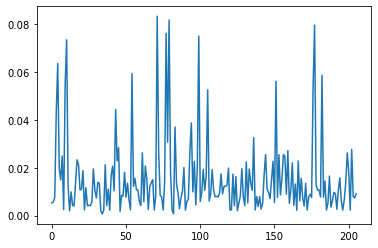

In [41]:
from matplotlib import pyplot as plt
plt.plot(scores)

In [42]:
s = []
for i in range(len(scores)):
    if scores[i] > 0.02:
        #print(i)
        s+=[target_cols[i]]
        

# LGBM

In [43]:
columns_1 = [
    '5-alpha_reductase_inhibitor',
    '11-beta-hsd1_inhibitor',
    'adenylyl_cyclase_activator',
    'aldehyde_dehydrogenase_inhibitor',
    'ampk_activator',
    'analgesic',
    'antiarrhythmic',
    'anticonvulsant',
    'antifungal',
    'antihistamine',
    'antimalarial',
    'antiviral',
    'atm_kinase_inhibitor',
    'atp-sensitive_potassium_channel_antagonist',
    'atp_synthase_inhibitor',
    'atr_kinase_inhibitor',
    'autotaxin_inhibitor',
    'bacterial_membrane_integrity_inhibitor',
    'calcineurin_inhibitor',
    'caspase_activator',
    'catechol_o_methyltransferase_inhibitor',
    'cck_receptor_antagonist',
    'chk_inhibitor',
    'coagulation_factor_inhibitor',
    'diuretic',
    'elastase_inhibitor',
    'erbb2_inhibitor',
    'farnesyltransferase_inhibitor',
    'focal_adhesion_kinase_inhibitor',
    'free_radical_scavenger',
    'fungal_squalene_epoxidase_inhibitor',
    'glutamate_inhibitor',
    'gonadotropin_receptor_agonist',
    'histone_lysine_demethylase_inhibitor',
    'hsp_inhibitor',
    'ikk_inhibitor',
    'laxative',
    'leukotriene_inhibitor',
    'lipase_inhibitor',
    'lxr_agonist',
    'mdm_inhibitor',
    'monoacylglycerol_lipase_inhibitor',
    'monopolar_spindle_1_kinase_inhibitor',
    'nicotinic_receptor_agonist',
    'nitric_oxide_production_inhibitor',
    'norepinephrine_reuptake_inhibitor',
    'nrf2_activator',
    'pdk_inhibitor',
    'progesterone_receptor_antagonist',
    'proteasome_inhibitor',
    'protein_phosphatase_inhibitor',
    'protein_tyrosine_kinase_inhibitor',
    'ras_gtpase_inhibitor',
    'retinoid_receptor_antagonist',
    'steroid',
    'syk_inhibitor',
    'tgf-beta_receptor_inhibitor',
    'thrombin_inhibitor',
    'tlr_antagonist',
    'transient_receptor_potential_channel_antagonist',
    'tropomyosin_receptor_kinase_inhibitor',
    'trpv_agonist',
    'ubiquitin_specific_protease_inhibitor',
    'vitamin_d_receptor_agonist'
]

In [44]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import log_loss



params_1 = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'boost_from_average': True,
    'num_threads': 4,
    'random_state': 42,
    
    'learning_rate': 0.01,
    
    # from Optuna result in Version 7
    'num_leaves': 212,
    'min_data_in_leaf': 92,
    'min_child_weight': 0.0010123391323415569,
    'max_depth': 35,
    'bagging_fraction': 0.7968351296815959,
    'feature_fraction': 0.7556374471450119,
    'lambda_l1': 0.23497601594060086,
    'lambda_l2': 0.15889208239516134
}
params_2 = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'boost_from_average': True,
    'num_threads': 4,
    'random_state': 42,
    
    'learning_rate': 0.01,
    
    # from Optuna result in Version 15
    'num_leaves': 106,
    'min_data_in_leaf': 176,
    'min_child_weight': 0.08961015929882983,
    'max_depth': 3,
    'bagging_fraction': 0.5672004837454858,
    'feature_fraction': 0.611628226420641,
    'lambda_l1': 1.293005852529098,
    'lambda_l2': 1.6012450757049599
}

In [45]:
import datetime
import random
import pickle
import zipfile
from collections import Counter

def run_training_lgbm(fold, seed, col):
    
    seed_everything(seed)
    
    train = process_data(folds)
    test_ = process_data(test)
    
    trn_idx = train[train['kfold'] != fold].index
    val_idx = train[train['kfold'] == fold].index
    
    train_df = train[train['kfold'] != fold].reset_index(drop=True)
    valid_df = train[train['kfold'] == fold].reset_index(drop=True)
    
    x_train, y_train  = train_df[feature_cols].values, train_df[col].values
    x_valid, y_valid =  valid_df[feature_cols].values, valid_df[col].values
    x_test = test_[feature_cols].values
    oof = np.zeros(len(train))
    trn_data = lgb.Dataset(x_train, label=y_train)
    val_data = lgb.Dataset(x_valid, label=y_valid)
    if col in columns_1:
        print('Params 1')
        params = params_1
    else:
        print('Params 2')
        params = params_2
    clf = lgb.train(params, trn_data, 10000, valid_sets = [trn_data, val_data], verbose_eval=0, early_stopping_rounds=20)
    oof_tr = clf.predict(x_train)
    oof[val_idx] = clf.predict(x_valid)
    predictions = clf.predict(x_test) 
    
    print('loss = ', log_loss(y_train, oof_tr))
    print('val_loss = ', log_loss(y_valid, oof[val_idx]))
    
    
    return oof, predictions

In [46]:
def run_k_fold_lgbm(NFOLDS, seed, col):
    oof = np.zeros(len(train))
    predictions = np.zeros(len(test))
    
    for fold in range(NFOLDS):
        print('*'*25,' ',fold,' ','*'*25)
        oof_, pred_ = run_training_lgbm(fold, seed, col)
        
        predictions += pred_ / NFOLDS
        oof += oof_
        
    return oof, predictions

In [47]:
# Averaging on multiple SEEDS

SEED = [1903, 1881, 1589]
oof = np.zeros((len(train), len(s)))
predictions = np.zeros((len(test), len(s)))
for m, col in enumerate(s):
    print('+'*25,' ',m,' ','+'*25)
    for seed in SEED:
        print('_'*25,'seed','-'*25)
        oof_, predictions_ = run_k_fold_lgbm(NFOLDS, seed, col)
        oof[:,m] += oof_ / len(SEED)
        predictions[:,m] += predictions_ / len(SEED)

train[s] = oof
test[s] = predictions

+++++++++++++++++++++++++   0   +++++++++++++++++++++++++
_________________________ seed -------------------------
*************************   0   *************************
Params 2
loss =  0.031039348094235853
val_loss =  0.046164243414958374
*************************   1   *************************
Params 2
loss =  0.04037551908736329
val_loss =  0.04781954842919325
*************************   2   *************************
Params 2
loss =  0.043972764280322506
val_loss =  0.048653626053162854
*************************   3   *************************
Params 2
loss =  0.043309414245719054
val_loss =  0.04823142095406188
*************************   4   *************************
Params 2
loss =  0.04002036947300984
val_loss =  0.04838081178133611
_________________________ seed -------------------------
*************************   0   *************************
Params 2
loss =  0.031039348094235853
val_loss =  0.046164243414958374
*************************   1   *************************
P

In [48]:
valid_results = train_targets_scored.drop(columns=target_cols).merge(train[['sig_id']+target_cols], on='sig_id', how='left').fillna(0)


y_true = train_targets_scored[target_cols].values
y_pred = valid_results[target_cols].values

score = 0
scores = []
for i in range(len(target_cols)):
    score_ = log_loss(y_true[:, i], y_pred[:, i])
    score += score_ / 206
    scores += [score_]
print("CV log_loss after LGBM: ", score)

CV log_loss after LGBM:  0.015275807169971782


# Submission

In [49]:
sub = sample_submission.drop(columns=target_cols).merge(test[['sig_id']+target_cols], on='sig_id', how='left').fillna(0)
sub.to_csv('submission.csv', index=False)

In [50]:
sub.shape

(3982, 207)